# Imports

In [2]:
import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from src.metrics import *
from src.metrics import eval_plugin
from src.synthesizer import fit_ctgan
from src.utils import *

seed = 0
seed_everything(seed)


/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [3]:
from src.data_loader import load_adult_data

dataset_name = "adult"
X_train, X_test, y_train, y_test, X, y = load_adult_data()

Data = X
Data["y"] = y


# Splits

In [4]:
X_train, X_test = train_test_split(Data, test_size=0.65, random_state=seed)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=seed)

X_train, X_hp = train_test_split(X_train, test_size=0.1, random_state=seed)


# Train Synthesizer

In [5]:
discrete_columns = [
    "education-num",
    "marital-status",
    "employment_type",
    "relationship",
    "race",
    "sex",
    "country",
    "y",
]

best_params = {"learning_rate": 0.0002, "embedding_dim": 256, "epochs": 300}
ctgan = fit_ctgan(
    data=X_val,
    epochs=best_params["epochs"],
    learning_rate=best_params["learning_rate"],
    embedding_dim=best_params["embedding_dim"],
    seed=seed,
    discrete_columns=discrete_columns,
)


# Train downstream models

In [6]:
model_dict = {
    "rf": RandomForestClassifier(random_state=seed),
}

trained_model_dict = train_models(X_train, model_dict)


In [7]:
column_metric = "race"
groups = list(np.unique(Data[column_metric]))


# See the effect of imperfect synthetic data in a controlled manner

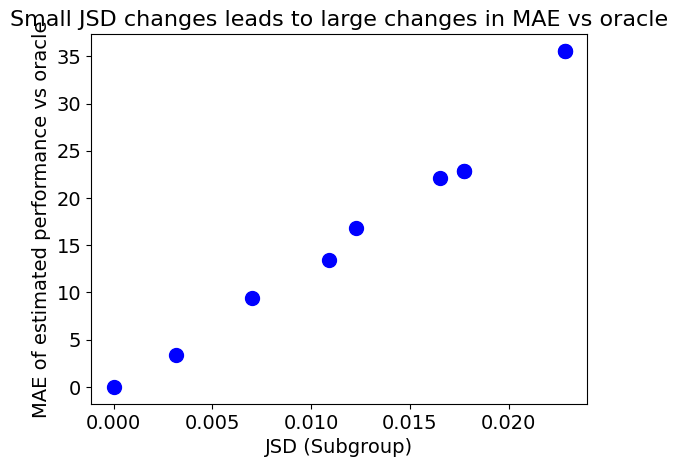

In [8]:
group = 4
jsd_scores = []
mae_scores = []


def flip_labels(y, p):
    y_flipped = y.copy()  # create a copy of y
    n_flips = int(len(y) * p)  # calculate the number of flips based on proportion p
    flip_indices = np.random.choice(
        len(y), n_flips, replace=False
    )  # select random indices to flip
    y_flipped[flip_indices] = (
        1 - y_flipped[flip_indices]
    )  # flip the labels at the selected indices
    return y_flipped


for pval in np.arange(0, 50, 5):
    p = pval / 100
    n_samples = 1000
    if group == 0:
        total_samples = 1000
    else:
        total_samples = 10000

    performance_per_group = {}

    oracle_data = X_test[X_test[column_metric] == group]
    model = "rf"
    clf = model_dict[model]
    y_pred = clf.predict(oracle_data.drop("y", axis=1))

    accuracy_oracle = accuracy_score(oracle_data["y"], y_pred)

    performance_per_group = {}
    shift_df, _ = ctgan.sample(
        1, shift=False, condition_column=column_metric, condition_value=group
    )

    count = 0
    while shift_df.shape[0] <= total_samples:

        generated_tmp, _ = ctgan.sample(
            n_samples,
            shift=False,
            condition_column=column_metric,
            condition_value=group,
        )

        tmp_df = generated_tmp[generated_tmp[column_metric] == group]

        shift_df = shift_df.append(tmp_df)
        count += 1

    shift_df.shape, count
    syn_data = deepcopy(oracle_data)
    syn_data["y"] = flip_labels(syn_data["y"].values, p)

    clf = model_dict[model]
    y_pred = clf.predict(syn_data.drop("y", axis=1))

    accuracy_syn = accuracy_score(syn_data["y"], y_pred)

    metric = JensenShannonDistance
    trial_results = eval_plugin(
        metric,
        GenericDataLoader(syn_data.astype(float)),
        GenericDataLoader(oracle_data.astype(float)),
    )
    try:
        jsd_scores.append(
            (trial_results[0]["marginal"], abs(accuracy_syn - accuracy_oracle))
        )
    except:
        jsd_scores.append(
            (trial_results[0]["joint"], abs(accuracy_syn - accuracy_oracle))
        )


import matplotlib.pyplot as plt

plt.style.reload_library()
SMALL_SIZE = 16
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

x_coords, y_coords = zip(*jsd_scores)
plt.scatter(x_coords, np.array(y_coords) * 100, color="b", marker="o", s=100)
plt.xlabel("JSD (Subgroup)")
plt.ylabel("MAE of estimated performance vs oracle")
plt.title("Small JSD changes leads to large changes in MAE vs oracle")
plt.show()
